# Symbolic Aggregate approXimation *(SAX)* Encoding
## Anomaly Detection DEMO

In [1]:
# at first time install pynuTS with this command
#!pip install git+https://github.com/nickprock/pynuTS.git@main

In [2]:
import pandas as pd
import numpy as np
from pynuTS.decomposition import NaiveSAX

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## Introduction

Symbolic Aggregate approXimation Encoding (SAX Encoding)

* Developed in 2002 by Keogh e Lin
* Dimensionality Reduction for sequences

* In this example we will use it to find anomaly patterns. For more informations read this [KDNuggets article](https://www.kdnuggets.com/2019/09/time-series-baseball.html).

## Create dataset.

We Create 10 sequences with 12 observations.


In [4]:
# Some useful functions
def sigmoid(x, a, b, c):
    expo = a * (b - x)
    sig = 1 / ( 1 + np.exp( expo ) ) * c
    return sig


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [6]:
time = np.arange(12)

np.random.seed(42)
a = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.5, -3, 5]
b = 10
c = 20

list_series = []
for i in range(10):
  noise = white_noise(time)
  temp = sigmoid(time, a[i], b, c) + noise
  list_series.append(temp)

### Create DataFrame

* every row is a period
* every column is a sequence

In [7]:
X = pd.DataFrame(list_series).T

In [9]:
X

,0,1,2,3,4,5,6,7,8,9
0,0.242129,0.962003,-1.462518,0.439687,0.464405,-0.721352,5.028685,-0.111706,19.896288,0.865030
1,0.085083,-0.375446,-1.305684,0.400787,-0.080513,0.436414,5.017171,-1.234888,19.985578,1.007047
2,0.398111,-0.591159,1.585422,1.352262,1.550438,0.568314,5.475095,0.063654,19.460661,-0.418465
3,0.787656,0.058371,0.618394,1.088667,0.928384,-1.381608,6.518939,0.984973,20.713421,0.269089
4,1.362687,1.145703,2.921814,0.926896,2.843568,0.662136,7.888473,-0.280837,20.161305,-0.960985
5,0.933467,1.587344,2.354154,1.843538,1.865496,1.195761,7.028164,0.386290,21.104835,1.844253
6,1.427827,1.227262,3.754954,1.026265,4.200735,3.493715,6.474350,1.768191,18.946334,-1.123375
7,3.886484,4.092905,3.276779,4.846264,5.607118,2.263385,7.845828,6.157710,20.081152,2.338767
8,5.920881,5.633687,5.325796,4.770415,4.807465,5.263438,9.183160,4.284007,20.662981,1.487010
9,8.670381,6.984421,6.865988,7.701885,6.709013,8.901403,10.365181,9.030690,19.322061,-0.145701


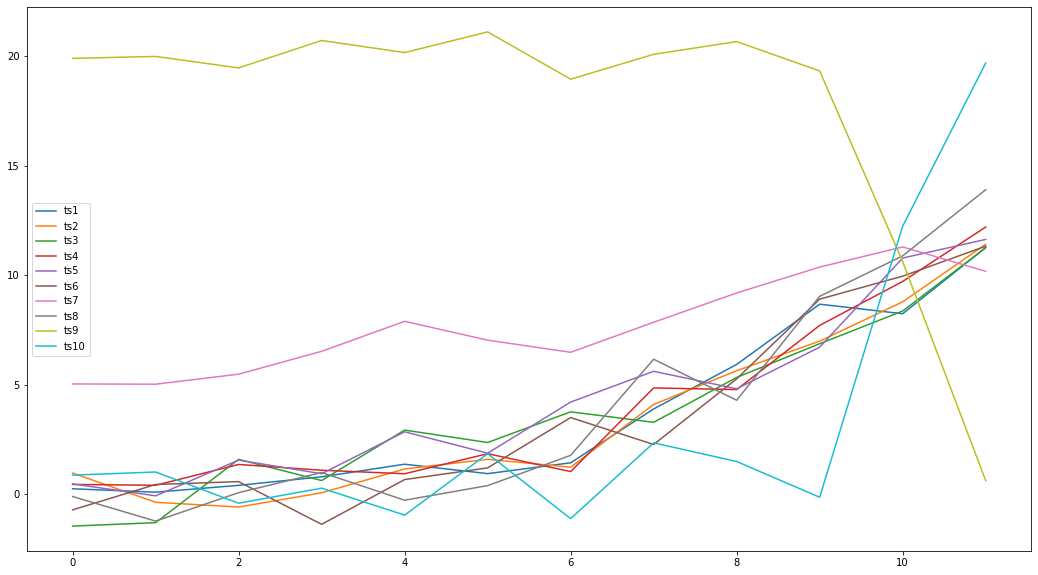

In [10]:
X.plot(figsize=(18,10))
plt.legend(["ts1", "ts2","ts3","ts4","ts5","ts6","ts7","ts8","ts9","ts10"])
plt.show()

## Anomaly detection with SAX Encoding

We choose a window size 4. We reduct the 12 periods in 3 periods, like quarters in a year.
You transpose X because each row must be a time series and each column a timestep.

In [11]:
sax = NaiveSAX(windows=4)

In [12]:
sax_strings = np.apply_along_axis(sax.fit_transform, 1, X.T)

## Dimensionality Reduction with **Piecewise Aggregate Approximation**

The **Piecewise Aggregate Approximation** consisting in taking the mean over back-to-back points. This decreases the number of points and reduces noise while preserving the trend of the time series.
The labels for each level form the **SAX String** (like *'AAA'*)

<br>

![PAA](https://www.researchgate.net/profile/Bill-Chiu-2/publication/221653289/figure/fig7/AS:668838362349575@1536474900462/Symbolic-aggregate-approximation-of-a-time-series-as-the-four-letter-word-dbad-The.ppm)

<br>

In [13]:
sax_strings

array(['ABC', 'ABC', 'ABC', 'ABC', 'ABC', 'ABC', 'ABC', 'ABC', 'BCA',
       'ABC'], dtype='<U3')

We create a new column and we count the occorrence

In [14]:
anomayX = X.T
anomayX["sax_strings"]=sax_strings

In [15]:
count = anomayX.sax_strings.value_counts().reset_index()

Now we define when a time series is an anomaly. In this example an anomaly is a time series with frequency 1.

In [16]:
anomaly_limit=1
anomayX["anomaly"] = False
anomayX.loc[anomayX['sax_strings'].isin(count.loc[count['sax_strings']==anomaly_limit, 'index']),'anomaly']=True

In [18]:
anomayX

,0,1,2,3,4,5,6,7,8,9,10,11,sax_strings,anomaly
0,0.242129,0.085083,0.398111,0.787656,1.362687,0.933467,1.427827,3.886484,5.920881,8.670381,8.235262,11.256495,ABC,False
1,0.962003,-0.375446,-0.591159,0.058371,1.145703,1.587344,1.227262,4.092905,5.633687,6.984421,8.779167,11.405761,ABC,False
2,-1.462518,-1.305684,1.585422,0.618394,2.921814,2.354154,3.754954,3.276779,5.325796,6.865988,8.359358,11.248636,ABC,False
3,0.439687,0.400787,1.352262,1.088667,0.926896,1.843538,1.026265,4.846264,4.770415,7.701885,9.709769,12.194564,ABC,False
4,0.464405,-0.080513,1.550438,0.928384,2.843568,1.865496,4.200735,5.607118,4.807465,6.709013,10.778704,11.628761,ABC,False
5,-0.721352,0.436414,0.568314,-1.381608,0.662136,1.195761,3.493715,2.263385,5.263438,8.901403,9.951197,11.318834,ABC,False
6,5.028685,5.017171,5.475095,6.518939,7.888473,7.028164,6.474350,7.845828,9.183160,10.365181,11.284884,10.174964,ABC,False
7,-0.111706,-1.234888,0.063654,0.984973,-0.280837,0.386290,1.768191,6.157710,4.284007,9.030690,10.878058,13.899369,ABC,False
8,19.896288,19.985578,19.460661,20.713421,20.161305,21.104835,18.946334,20.081152,20.662981,19.322061,10.613588,0.609741,BCA,True
9,0.865030,1.007047,-0.418465,0.269089,-0.960985,1.844253,-1.123375,2.338767,1.487010,-0.145701,12.234098,19.684002,ABC,False


### Plot the series

In blu the standard patterns

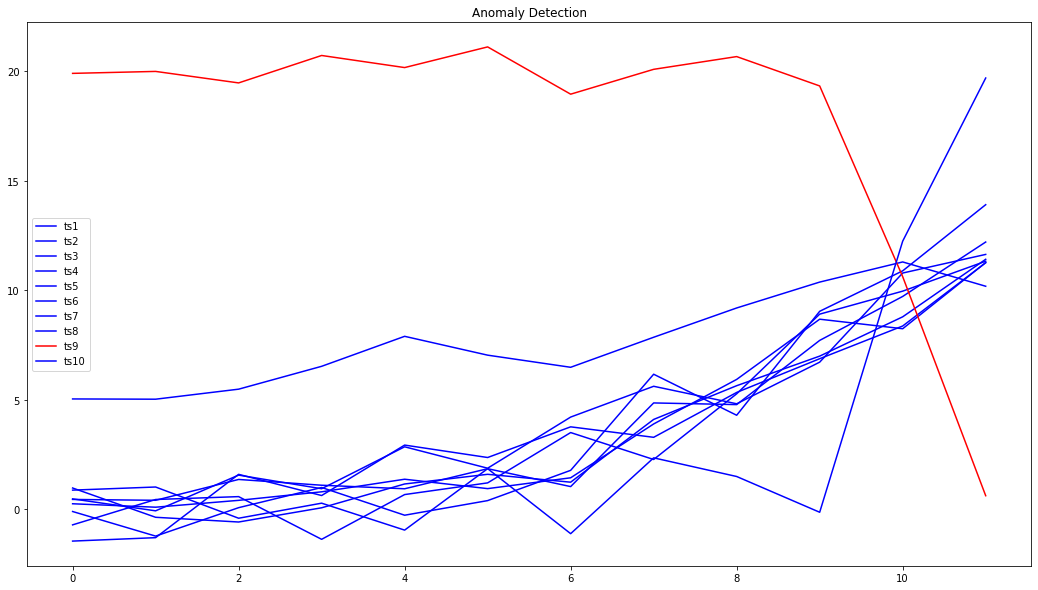

In [19]:
plt.figure(figsize=(18,10))
for i in range(anomayX.shape[0]):
    if anomayX.iloc[i,-1]:
        col = 'r'
    else:
        col = 'b'
    plt.plot(anomayX.iloc[i,:-2], col)
plt.legend(["ts1", "ts2","ts3","ts4","ts5","ts6","ts7","ts8","ts9","ts10"])
plt.title("Anomaly Detection")
plt.show()

## Credits

pynuTS by Nicola Procopio 2020

Original repository https://github.com/nickprock/pynuTS/

<br>

* *The **sigmoid** function was created by [Piero Savastano](https://github.com/pieroit) for [covid19italia](https://github.com/ondata/covid19italia/blob/master/visualizzazione/analisi_predittiva.ipynb)*

* *The **white_noise** function was created by [Aurélien Géron](https://github.com/ageron) for an Udacity course*
